In [2]:
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import re

quora_question_data = pd.read_csv('Dataset/train.csv')
quora_question_data['is_duplicate'] = quora_question_data['is_duplicate'].astype(int)
question = pd.concat([ quora_question_data.loc[:, ['qid1', 'question1']].rename(columns={'qid1': 'qid', 'question1': 'question'}), 
                      quora_question_data.loc[:, ['qid2', 'question2']].rename(columns={'qid2': 'qid', 'question2': 'question'}) ], axis=0)

question['question'] = question['question'].astype(str)
question['qid'] = question['qid'].astype(int)
question = question.sort_values(by='qid')
question = question.drop_duplicates(subset='qid', keep='first')
question = question.reset_index()
question = question.drop('index', axis=1)

def process_text(text): 
    # convert the text to lower case, and substitute space for any special characters
    return re.sub(r'[^a-zA-Z0-9\s]', ' ', text.lower())

question['question'] = question['question'].apply(process_text)
question['question'] = question['question'].astype(str)
question.sample(1)

,qid,question
301949,301950,why can t i forget my first love and my first ...


In [3]:
from tokenizers import Tokenizer, models, pre_tokenizers, trainers, processors

# Tokenizer Initialization
tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

# Trainer for the WordPiece tokenizer
trainer = trainers.WordPieceTrainer(
    vocab_size=10000,
    min_frequency=2,
    special_tokens=["[PAD]", "[CLS]", "[SEP]", "[UNK]", "[MASK]"]
)

corpus = question['question']

tokenizer.train_from_iterator(corpus, trainer)


tokenizer.post_processor = processors.TemplateProcessing(
    single="[CLS] $A",
    special_tokens=[("[CLS]", tokenizer.token_to_id("[CLS]")),]
)

vocab_size = len(tokenizer.get_vocab())
vocab_size

10000

In [4]:
def return_tokens(text):
    return tokenizer.encode(text).tokens

question['tokens'] = question['question'].apply(return_tokens)
question.sample(1)

,qid,question,tokens
215094,215095,who can design uber app,"[[CLS], who, can, design, uber, app]"


In [5]:
tagged_data = [
    TaggedDocument(words=row['tokens'], tags=[str(row['qid'])])
    for index, row in question.iterrows()
]

tagged_data[0]

TaggedDocument(words=['[CLS]', 'what', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market', 'in', 'india'], tags=['1'])

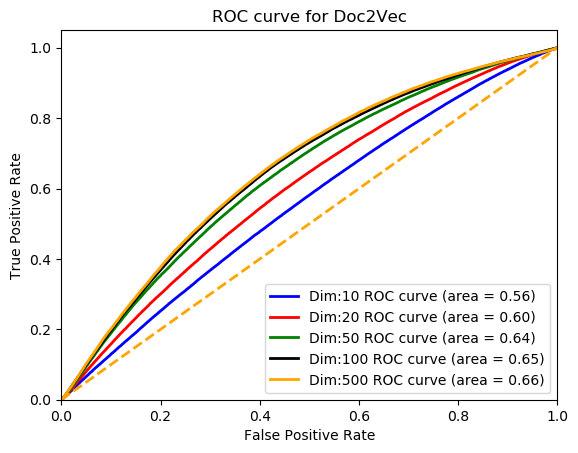

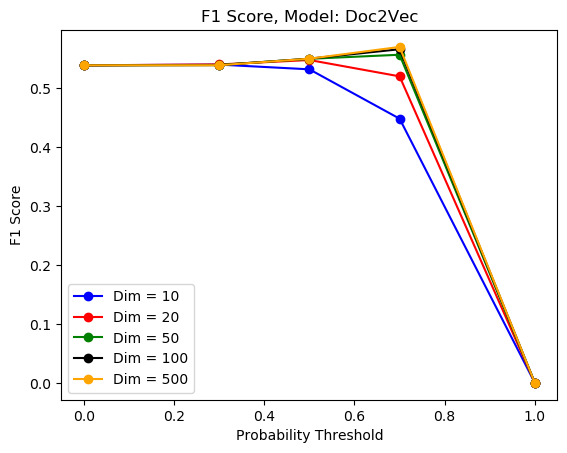

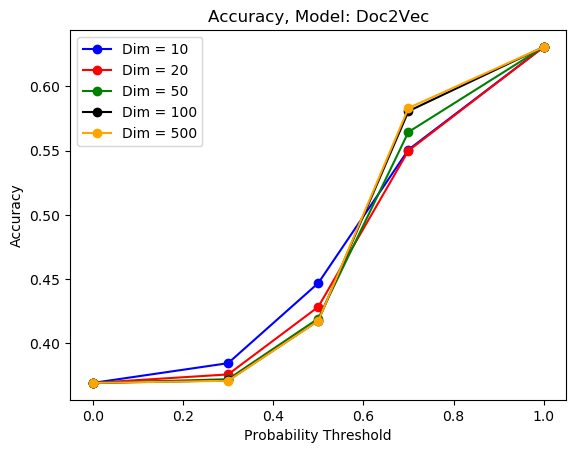

In [8]:
from sklearn.decomposition import PCA
import numpy as np
from sklearn.metrics import roc_curve, auc 
import matplotlib.pyplot as plt
from collections import defaultdict

embedding_dims = [10, 20, 50, 100, 500]
colors = ['b', 'r', 'g', 'black', 'orange']


def update_metrics(prob, is_true, prob_thresholds, metrics):
    for threshold, metric in zip(prob_thresholds, metrics):
        if prob >= threshold:
            if is_true:
                metric['tp'] += 1
            else:
                metric['fp'] += 1
        else:
            if is_true:
                metric['fn'] += 1 
            else:
                metric['tn'] += 1

f1_scores_all = []
accuracies_all = []    
fpr_all = []
tpr_all = []
for i, dim in enumerate(embedding_dims):

    model = Doc2Vec(
        vector_size=dim,  # Dimension of document embeddings
        window=5,         # Context window size
        min_count=2,      # Minimum word frequency
        workers=4,        # Number of worker threads
        epochs=5         # Number of training epochs
    )

    # Build vocabulary
    model.build_vocab(tagged_data)

    model.train(
        tagged_data, 
        total_examples=model.corpus_count, 
        epochs=model.epochs
    )

    y_true = []
    y_scores = []
    
    prob_thresholds = [0.0, 0.3, 0.5, 0.7, 1.0]
    metrics = [defaultdict(int) for _ in range(len(prob_thresholds))]

    for index, row in quora_question_data.iterrows():
        # using cosine similary
        qid1 = str(row['qid1'])
        qid2 = str(row['qid2'])
        
        embeeding_q1 = model.dv[qid1]
        embedding_q2 = model.dv[qid2]
        
        dot_product = np.dot(embeeding_q1, embedding_q2)
        norm_eq1 = np.linalg.norm(embeeding_q1)
        norm_eq2 = np.linalg.norm(embedding_q2)
        cosine_similarity = dot_product / (norm_eq1 * norm_eq2)

        prob = (cosine_similarity + 1) / 2
        
        y_true.append(row['is_duplicate']) 
        y_scores.append(prob)
        update_metrics(y_scores[-1], y_true[-1], prob_thresholds, metrics)
    
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    fpr_all.append(fpr)
    tpr_all.append(tpr)
    
    f1_scores = []
    accuracies = []
    for threshold, metric in zip(prob_thresholds, metrics):
        precision = metric['tp'] / (metric['tp'] + metric['fp']) if (metric['tp'] + metric['fp']) > 0 else 0
        recall = metric['tp'] / (metric['tp'] + metric['fn']) if (metric['tp'] + metric['fn']) > 0 else 0 
        accuracy = (metric['tp'] + metric['tn']) / (metric['tp'] + metric['tn'] + metric['fp'] + metric['fn']) if (metric['tp'] + metric['tn'] + metric['fp'] + metric['fn']) > 0 else 0 
        f1_score = 2 * recall * precision / (precision + recall) if (precision + recall) > 0 else 0
            
        f1_scores.append(f1_score)
        accuracies.append(accuracy)
    
    f1_scores_all.append(f1_scores)
    accuracies_all.append(accuracies)

plt.figure()
for i, (fpr, tpr) in enumerate(zip(fpr_all, tpr_all)):
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label='Dim:' + str(embedding_dims[i]) + ' ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color=colors[i], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Doc2Vec')
plt.legend(loc="lower right")
plt.show()

plt.figure()
for i, f1_scores in enumerate(f1_scores_all):
    plt.plot(prob_thresholds, f1_scores, marker='o', color=colors[i], label=f"Dim = {embedding_dims[i]}")
plt.xlabel("Probability Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score, Model: Doc2Vec")
plt.legend()
plt.show()

plt.figure()
for i, accuracies in enumerate(accuracies_all):
    plt.plot(prob_thresholds, accuracies, marker='o', color=colors[i], label=f"Dim = {embedding_dims[i]}")
plt.xlabel("Probability Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy, Model: Doc2Vec")
plt.legend()
plt.show()

In [9]:
for i, dim in enumerate(embedding_dims):
    for p, f1 in zip(prob_thresholds, f1_scores_all[i]):
        print(f"TF-IDF, dim = {dim}, prob_threshold = {p}, f1_score = {f1}")


for i, dim in enumerate(embedding_dims):
    for p, a in zip(prob_thresholds, accuracies_all[i]):
        print(f"TF-IDF, dim = {dim}, prob_threshold = {p}, accuracy = {a}")
    

TF-IDF, dim = 10, prob_threshold = 0.0, f1_score = 0.5392907273558268
TF-IDF, dim = 10, prob_threshold = 0.3, f1_score = 0.5404665645945032
TF-IDF, dim = 10, prob_threshold = 0.5, f1_score = 0.5324668535954519
TF-IDF, dim = 10, prob_threshold = 0.7, f1_score = 0.4486577731360321
TF-IDF, dim = 10, prob_threshold = 1.0, f1_score = 0
TF-IDF, dim = 20, prob_threshold = 0.0, f1_score = 0.5392907273558268
TF-IDF, dim = 20, prob_threshold = 0.3, f1_score = 0.5407432886180858
TF-IDF, dim = 20, prob_threshold = 0.5, f1_score = 0.5482789559383789
TF-IDF, dim = 20, prob_threshold = 0.7, f1_score = 0.5205283770748447
TF-IDF, dim = 20, prob_threshold = 1.0, f1_score = 0
TF-IDF, dim = 50, prob_threshold = 0.0, f1_score = 0.5392907273558268
TF-IDF, dim = 50, prob_threshold = 0.3, f1_score = 0.5398686271097963
TF-IDF, dim = 50, prob_threshold = 0.5, f1_score = 0.5503447747471653
TF-IDF, dim = 50, prob_threshold = 0.7, f1_score = 0.5572164079811464
TF-IDF, dim = 50, prob_threshold = 1.0, f1_score = 0
T

## discared
